In [170]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from skopt import BayesSearchCV
import subprocess
import matplotlib.pyplot as plt
import math  
import sklearn.metrics
import shap
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

# Feature pre-processing
#### Numerical Features
'id', 'scrape_id', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 
'host_total_listings_count','latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
'number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy',
'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
'review_scores_value','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms','reviews_per_month'

#### Categorical Features
'source', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_has_profile_pic', 
'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
'property_type','room_type', 'has_availability', 'instant_bookable', 'host_location'

#### Date Features
'last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review'

#### Text Features
'listing_url', 'name', 'description', 'neighbourhood_overview', 'picture_url', 
'host_url', 'host_name', 'host_about', 'hosr_thumbnail_url', 'host_picture_url', 
'host_verifications', 'bathrooms_text', 'amenities'

#### Empty Columns
'calendar_updated', 'bathrooms'

#### Dummu Column
'license'

In [171]:
data = pd.read_csv('listings.csv')
airbnb = pd.read_csv('airbnb_4.csv')
# Merge the two dataframes based on the 'id' column, concatenate 3 new features
merged_df = pd.merge(data, airbnb[['id', 'average_nearest_price', 'within_radius', 'bus_radius']], on='id')

In [172]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4887 entries, 0 to 4886
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4887 non-null   int64  
 1   listing_url                                   4887 non-null   object 
 2   scrape_id                                     4887 non-null   int64  
 3   last_scraped                                  4887 non-null   object 
 4   source                                        4887 non-null   object 
 5   name                                          4887 non-null   object 
 6   description                                   4866 non-null   object 
 7   neighborhood_overview                         3422 non-null   object 
 8   picture_url                                   4887 non-null   object 
 9   host_id                                       4887 non-null   i

### Since we face to new host, we select the features that is relevant to the feature price, ignored empty columns, identification features (id, name, etc.), high correlated featurs (host_listings_count, minimum_minimum_nights, etc), and past experience features, etc.

In [173]:
# 20 selected features
columns = ['latitude', 'longitude', 'host_total_listings_count','host_has_profile_pic', 
           'host_identity_verified','neighbourhood_cleansed', 'property_type', 'room_type', 
           'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 
           'has_availability', 'review_scores_value', 'instant_bookable', 
            'average_nearest_price', 'within_radius', 'bus_radius']
df = merged_df[columns].copy()

# Data Pre-processing

### 1. Count the number of NA in each column, and drop all rows have NA.

In [174]:
def count_na_by_column(data):
    for column in data.columns:
        print(column + ":", data[column].isna().sum())
count_na_by_column(df)
df = df.dropna()

latitude: 0
longitude: 0
host_total_listings_count: 0
host_has_profile_pic: 0
host_identity_verified: 0
neighbourhood_cleansed: 0
property_type: 0
room_type: 0
accommodates: 0
bathrooms_text: 2
bedrooms: 299
beds: 44
amenities: 0
price: 0
has_availability: 0
review_scores_value: 541
instant_bookable: 0
average_nearest_price: 5
within_radius: 0
bus_radius: 0


### 2. Convert the price to numeric values [extreme value removed]

In [175]:
def prices_to_numbers (price_string):
    price_numeric = float(str(price_string).replace(',', '').split('$')[-1])
    return price_numeric
df['price'] = df['price'].apply(prices_to_numbers)
df.price.head(2)

0    157.0
1    150.0
Name: price, dtype: float64

In [176]:
q_high = df['price'].quantile(0.95)
q_low = df['price'].quantile(0.05)
df = df[(df['price'] <= q_high) & (df['price'] >= q_low)]

### 3. Convert bool value to numeric.

In [177]:
from sklearn.preprocessing import LabelEncoder
boolean_cols = ['host_has_profile_pic',
               'host_identity_verified',
               'has_availability',
               'instant_bookable',
               'within_radius',
               'bus_radius']

le = LabelEncoder()

for col in boolean_cols:
    col_encoded = le.fit_transform(df[col])
    df[col] = le.fit_transform(df[col])
    # get the mappings of the encoded values
    mappings = dict(zip(range(len(le.classes_)), le.classes_))

    # print the mappings
    print("Mappings for %s: %s\n" % (col, mappings))

Mappings for host_has_profile_pic: {0: 'f', 1: 't'}

Mappings for host_identity_verified: {0: 'f', 1: 't'}

Mappings for has_availability: {0: 'f', 1: 't'}

Mappings for instant_bookable: {0: 'f', 1: 't'}

Mappings for within_radius: {0: False, 1: True}

Mappings for bus_radius: {0: False, 1: True}



### 4. Extract all kind of amenities from the text, create new amenity boolean features.

In [178]:
all_amenities = []
amenities_list = df.amenities.unique()

for i in range(len(amenities_list)):
    amenities = amenities_list[i].split(",")
    for ft in amenities:
        for amen in ft.split('"'):
            if amen != "[" and amen != "]" and amen not in all_amenities:
                all_amenities.append(amen)

We manually selected a few hot amenities to create new boolean features.

In [179]:
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
#df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3642 entries, 0 to 4886
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   3642 non-null   float64
 1   longitude                  3642 non-null   float64
 2   host_total_listings_count  3642 non-null   int64  
 3   host_has_profile_pic       3642 non-null   int64  
 4   host_identity_verified     3642 non-null   int64  
 5   neighbourhood_cleansed     3642 non-null   object 
 6   property_type              3642 non-null   object 
 7   room_type                  3642 non-null   object 
 8   accommodates               3642 non-null   int64  
 9   bathrooms_text             3642 non-null   object 
 10  bedrooms                   3642 non-null   float64
 11  beds                       3642 non-null   float64
 12  amenities                  3642 non-null   object 
 13  price                      3642 non-null   float

Replacing nulls with zeros for new columns

In [181]:
cols_to_replace_nulls = df.iloc[:,20:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

Next, we view the value set for all new columns

In [182]:
def printValuesForEachColumn(data):
    for amenity_column in data.columns[20:]:
        print(amenity_column, set(data[amenity_column]))
printValuesForEachColumn(df)

air_conditioning {0.0, 1.0}
high_end_electronics {0.0, 1.0}
bbq {0.0, 1.0}
balcony {0.0, 1.0}
nature_and_views {0.0, 1.0}
bed_linen {0.0, 1.0}
breakfast {0.0, 1.0}
tv {0.0, 1.0}
coffee_machine {0.0, 1.0}
cooking_basics {0.0, 1.0}
white_goods {0.0, 1.0}
elevator {0.0, 1.0}
gym {0.0, 1.0}
child_friendly {0.0, 1.0}
parking {0.0, 1.0}
outdoor_space {0.0, 1.0}
host_greeting {0.0, 1.0}
hot_tub_sauna_or_pool {0.0, 1.0}
internet {0.0, 1.0}
long_term_stays {0.0, 1.0}
pets_allowed {0.0, 1.0}
private_entrance {0.0, 1.0}
secure {0.0, 1.0}
smoking_allowed {0.0, 1.0}


We did not observe any column contains a single value only.

Dropping the original amenities column

In [183]:
df.drop('amenities', axis=1, inplace=True)

### 5. Displays the property type of listings

In [184]:
property_type_counts = df.property_type.value_counts()
property_type_counts

Entire condo                          1042
Entire rental unit                     658
Entire home                            592
Entire guest suite                     526
Private room in home                   284
Entire loft                            107
Entire townhouse                        67
Private room in rental unit             62
Private room in condo                   54
Entire guesthouse                       52
Entire serviced apartment               48
Private room in villa                   24
Private room in townhouse               20
Private room in guest suite             16
Entire villa                            11
Entire bungalow                         10
Room in boutique hotel                   9
Private room in bed and breakfast        7
Entire place                             6
Room in aparthotel                       5
Entire cottage                           4
Private room in bungalow                 4
Entire timeshare                         4
Tiny home  

Grouping property types whose low counts might be insignificant and not provide us with enough information.
Thus, grouping property types that have counts that are < 20 into 'Other'.

In [185]:
df.loc[df.property_type.isin(property_type_counts[property_type_counts<20].keys()), 'property_type'] = 'Other'
df.property_type.value_counts()

Entire condo                   1042
Entire rental unit              658
Entire home                     592
Entire guest suite              526
Private room in home            284
Entire loft                     107
Other                           106
Entire townhouse                 67
Private room in rental unit      62
Private room in condo            54
Entire guesthouse                52
Entire serviced apartment        48
Private room in villa            24
Private room in townhouse        20
Name: property_type, dtype: int64

### 6. Extract the features of bathrooms number and bathroom type from the text column 'bathrooms_text'

In [186]:
list(set(df.bathrooms_text))[0:10]

['1 private bath',
 '1.5 baths',
 '0 shared baths',
 '1.5 shared baths',
 'Shared half-bath',
 '2.5 baths',
 '3 baths',
 '5 baths',
 '6 baths',
 '3 shared baths']

In [187]:
def convertBathrooms(row):  
    if 'private' in row['bathrooms_text'].lower():
        return 'private'
    elif 'shared' in row['bathrooms_text'].lower():
        return 'shared'
    return 'unknown'

df['bathrooms_type'] = df.apply(lambda row: convertBathrooms(row), axis=1)
df.bathrooms_type.value_counts()

unknown    3188
private     228
shared      226
Name: bathrooms_type, dtype: int64

Now we extract the bathroom number

In [188]:
def calculateBathroomNum(row):  
    if 'half' in row['bathrooms_text'].lower() or 'Half' in row['bathrooms_text'].lower():
        return 0.5
    return float(row['bathrooms_text'].split(" ")[0])

df['bathrooms_number'] = df.apply(lambda row: calculateBathroomNum(row), axis=1)
df.bathrooms_number.value_counts()

1.0    2722
2.0     598
1.5     174
2.5      89
3.0      27
3.5      14
4.0       7
4.5       4
0.0       2
0.5       2
6.0       1
5.0       1
7.0       1
Name: bathrooms_number, dtype: int64

Drop the original column 'bathrooms_text'

In [189]:
df.drop('bathrooms_text', axis=1, inplace=True)

### 7. Encode other categorical features.

In [190]:
boolean_cols = ['neighbourhood_cleansed',
               'property_type',
               'room_type',
               'bathrooms_type']

le = LabelEncoder()

for col in boolean_cols:
    col_encoded = le.fit_transform(df[col])
    df[col] = le.fit_transform(df[col])
    # get the mappings of the encoded values
    mappings = dict(zip(range(len(le.classes_)), le.classes_))

    # print the mappings
    print("Mappings for %s: %s\n" % (col, mappings))

Mappings for neighbourhood_cleansed: {0: 'Arbutus Ridge', 1: 'Downtown', 2: 'Downtown Eastside', 3: 'Dunbar Southlands', 4: 'Fairview', 5: 'Grandview-Woodland', 6: 'Hastings-Sunrise', 7: 'Kensington-Cedar Cottage', 8: 'Kerrisdale', 9: 'Killarney', 10: 'Kitsilano', 11: 'Marpole', 12: 'Mount Pleasant', 13: 'Oakridge', 14: 'Renfrew-Collingwood', 15: 'Riley Park', 16: 'Shaughnessy', 17: 'South Cambie', 18: 'Strathcona', 19: 'Sunset', 20: 'Victoria-Fraserview', 21: 'West End', 22: 'West Point Grey'}

Mappings for property_type: {0: 'Entire condo', 1: 'Entire guest suite', 2: 'Entire guesthouse', 3: 'Entire home', 4: 'Entire loft', 5: 'Entire rental unit', 6: 'Entire serviced apartment', 7: 'Entire townhouse', 8: 'Other', 9: 'Private room in condo', 10: 'Private room in home', 11: 'Private room in rental unit', 12: 'Private room in townhouse', 13: 'Private room in villa'}

Mappings for room_type: {0: 'Entire home/apt', 1: 'Hotel room', 2: 'Private room', 3: 'Shared room'}

Mappings for bathr

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3642 entries, 0 to 4886
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   3642 non-null   float64
 1   longitude                  3642 non-null   float64
 2   host_total_listings_count  3642 non-null   int64  
 3   host_has_profile_pic       3642 non-null   int64  
 4   host_identity_verified     3642 non-null   int64  
 5   neighbourhood_cleansed     3642 non-null   int64  
 6   property_type              3642 non-null   int64  
 7   room_type                  3642 non-null   int64  
 8   accommodates               3642 non-null   int64  
 9   bedrooms                   3642 non-null   float64
 10  beds                       3642 non-null   float64
 11  price                      3642 non-null   float64
 12  has_availability           3642 non-null   int64  
 13  review_scores_value        3642 non-null   float

In [192]:
df.review_scores_value.describe()

count    3642.000000
mean        4.687298
std         0.364143
min         1.000000
25%         4.610000
50%         4.770000
75%         4.880000
max         5.000000
Name: review_scores_value, dtype: float64

In [195]:
df.to_csv('airbnb_model_fitting.csv', index=False)

## Feature Selection

In [193]:
X = df.loc[:, df.columns != 'review_scores_value']
y = df['review_scores_value']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1, train_size = 0.9,  random_state=42)

In [194]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import warnings
warnings.filterwarnings("ignore")

selector = SelectKBest(mutual_info_regression, k=12)

X_new = selector.fit_transform(X_train, y_train)

X_train_selected = X_train.iloc[:, selector.get_support(indices=True)]
X_test_selected = X_test.iloc[:, selector.get_support(indices=True)]


X_train_selected['bus_radius'] = X_train.iloc[:, X_train.columns.get_loc('bus_radius')]
X_train_selected['within_radius'] = X_train['within_radius']
#X_train_selected['average_nearest_price'] = X_train['average_nearest_price']
X_train_selected['price'] = X_train['price']

X_test_selected['bus_radius'] = X_test['bus_radius']
X_test_selected['within_radius'] = X_test['within_radius']
#X_test_selected['average_nearest_price'] = X_test['average_nearest_price']
X_test_selected['price'] = X_test['price']

X_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3277 entries, 2861 to 4151
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   3277 non-null   float64
 1   longitude                  3277 non-null   float64
 2   host_total_listings_count  3277 non-null   int64  
 3   neighbourhood_cleansed     3277 non-null   int64  
 4   property_type              3277 non-null   int64  
 5   air_conditioning           3277 non-null   float64
 6   balcony                    3277 non-null   float64
 7   bed_linen                  3277 non-null   float64
 8   elevator                   3277 non-null   float64
 9   parking                    3277 non-null   float64
 10  outdoor_space              3277 non-null   float64
 11  internet                   3277 non-null   float64
 12  bus_radius                 3277 non-null   int64  
 13  within_radius              3277 non-null   in

## Model Selection

### 1. KNN

In [196]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_standarized = scaler.fit_transform(X_train)

knn = KNeighborsRegressor(n_neighbors=3)

kfold = KFold(n_splits=20, shuffle=True, random_state=42)

scores = cross_val_score(knn, X_train_standarized, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

rmse = -scores.mean()

print(f"Average RMSE: {rmse:.2f}")

Average RMSE: 0.36


### 2. SVR

In [197]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold

svm_regressor = SVR(kernel='rbf', C=3)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(svm_regressor, X_train_standarized, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

rmse = -scores.mean()

print(f"Average RMSE: {rmse:.2f}")

Average RMSE: 0.35


### 3. Random Forest

In [198]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

kfold = KFold(n_splits=20, shuffle=True, random_state=42)

scores = cross_val_score(estimator=rf, X=X_train_standarized, y=y_train, cv=kfold, 
                         scoring='neg_root_mean_squared_error')

rmse = -scores.mean()

print(f"Average RMSE: {rmse:.2f}")

Average RMSE: 0.33


### 4. Gradient Boosting

In [199]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)

kfold = KFold(n_splits=20, shuffle=True, random_state=42)

scores = cross_val_score(estimator=gb, X=X_train_standarized, y=y_train, cv=kfold, scoring='neg_root_mean_squared_error')

rmse = -scores.mean()

print(f"Average RMSE: {rmse:.2f}")

Average RMSE: 0.34


### 5. Lasso Regression

In [200]:
from sklearn.linear_model import Lasso
import numpy as np
lasso = Lasso(alpha=7)

scores = cross_val_score(lasso, X=X_train_standarized, y=y_train, cv=20, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)

print(f"Average RMSE: {rmse_scores.mean():.2f}")

Average RMSE: 0.36


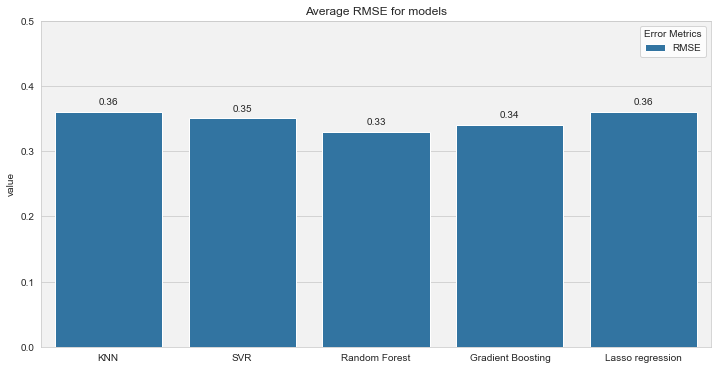

In [201]:
data = {' ': ['KNN', 'SVR', 'Random Forest','Gradient Boosting', 'Lasso regression'],
        'Error Metrics': ['RMSE', 'RMSE', 'RMSE', 'RMSE', 'RMSE'],
        'value': [0.36, 0.35, 0.33, 0.34, 0.36]}
df_scores = pd.DataFrame(data)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=" ", y="value", hue="Error Metrics", data=df_scores)
ax.set_title('Average RMSE for models')

ax.set_facecolor('#f2f2f2')
plt.ylim([0, 0.5])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=10)
plt.savefig('model_selection.png', dpi=300, bbox_inches='tight')

## SAVE, Test Data Preprocessing

In [202]:
import warnings
warnings.filterwarnings("ignore")

In [203]:
X_train_selected.to_csv('preprocessed_X_train.csv',index=False)
y_train.to_csv('preprocessed_y_train.csv',index=False)
X_test_selected.to_csv('preprocessed_X_test.csv',index=False)
y_test.to_csv('preprocessed_y_test.csv',index=False)

In [204]:
#!pip install nbconvert

In [205]:
subprocess.check_call(['jupyter', 'nbconvert', '--to', 'notebook', '--execute', 'feature_patch_2.ipynb'])

[NbConvertApp] Converting notebook feature_patch_2.ipynb to notebook
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 3796806 bytes to feature_patch_2.nbconvert.ipynb


0

# Model tuning and fitting

Tree regression is a technique that is able to perform both regression and classification task with decision tree. Since our dataset contains many categorical variables, we choose to use the tree regressor becuase it potentially more friendly with categorical variables.

## Model Trained without average nearby listing price feature

In [206]:
X_train_1 = X_train_selected
y_train_1 = y_train

X_test_1 = pd.read_csv('preprocessed_2_X_test_1.csv', sep=',')
y_test_1 = pd.read_csv('preprocessed_2_y_test_1.csv', sep=',')

### 1. Random forest regression

In [207]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# Define hyperparameter grid to search over
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2', None],
}

# Define the Random Forest classifier model
rf = RandomForestRegressor()

# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X_train_1, y_train_1)

# Print the best hyperparameters and resulting accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 40}
Best accuracy score:  -0.33705673296307737


In [208]:
rf = RandomForestRegressor(n_estimators = 40, max_features = 'sqrt', max_depth = 10, random_state=42)
rf.fit(X_train_1, y_train_1)
y_predict_rf = rf.predict(X_test_1)

In [209]:
importancesRF = rf.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
host_total_listings_count,0.183330
longitude,0.173567
latitude,0.167672
price,0.143268
neighbourhood_cleansed,0.062378


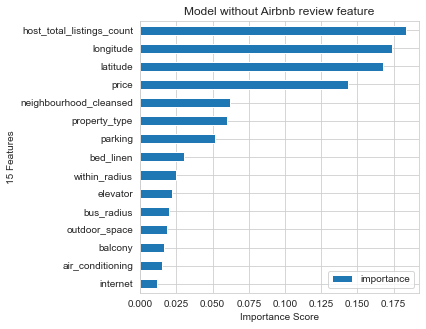

In [210]:
feat_imp = pd.DataFrame({'importance':rf.feature_importances_})  
feat_imp['feature'] = X_train_1.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp = feat_imp[len(feat_imp1)-15:len(feat_imp1)]
feat_imp.plot.barh(figsize=(5,5))
plt.xlabel('Importance Score')
plt.ylabel('15 Features')
plt.title('Model without Airbnb review feature')
plt.show()

In [211]:
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict_rf)  
mae_rf_1 = sklearn.metrics.mean_absolute_error(y_test_1, y_predict_rf) 

rmse_rf_1 = math.sqrt(mse)  

print("RMSE = ", rmse_rf_1)
print("MAE = ", mae_rf_1)

RMSE =  0.5332371333037542
MAE =  0.2801540233785174


In [34]:
import pickle
# save the model to disk
filename = 'review-rf01.sav'
pickle.dump(rf, open(filename, 'wb'))

In [129]:
shap.initjs()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_1)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_1.iloc[0,:])

### 2. Gradient boosting regression

In [212]:
# Define hyperparameter grid to search over
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.03, 0.06],
    'max_features': ['sqrt', 'log2', None],
}

# Define the Random Forest classifier model
gb = GradientBoostingRegressor()

# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(
    gb, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X_train_1, y_train_1)

# Print the best hyperparameters and resulting accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best hyperparameters:  {'learning_rate': 0.03, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 40}
Best accuracy score:  -0.339731030420262


In [232]:
grad_boosting_tree = GradientBoostingRegressor(n_estimators=40, learning_rate = 0.03, max_features = 'log2', 
                                               max_depth = 10, random_state=42)

grad_boosting_tree.fit(X_train_1, y_train_1)
y_predict_gb = grad_boosting_tree.predict(X_test_1)

In [233]:
importancesRF = grad_boosting_tree.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
longitude,0.192802
host_total_listings_count,0.192347
latitude,0.159157
price,0.149097
property_type,0.066249


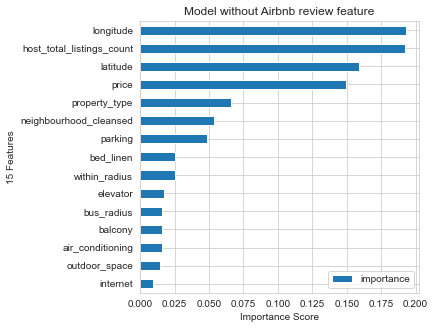

In [234]:
feat_imp = pd.DataFrame({'importance':grad_boosting_tree.feature_importances_})  
feat_imp['feature'] = X_train_1.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp = feat_imp[len(feat_imp1)-15:len(feat_imp1)]
feat_imp.plot.barh(figsize=(5,5))
plt.xlabel('Importance Score')
plt.ylabel('15 Features')
plt.title('Model without Airbnb review feature')
f = plt.gcf()
plt.show()
f.savefig("gb_importance_15.png", dpi=300, bbox_inches="tight")

In [235]:
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict_gb)  
mae_gb_1 = sklearn.metrics.mean_absolute_error(y_test_1, y_predict_gb) 

rmse_gb_1 = math.sqrt(mse)  

print("RMSE = ", rmse_gb_1)
print("MAE = ", mae_gb_1)

RMSE =  0.5274743278166919
MAE =  0.2755916442173168


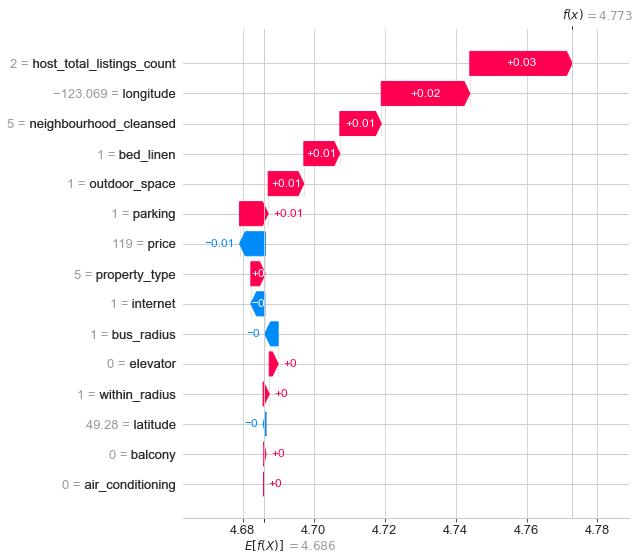

In [239]:
shap.initjs()

explainer = shap.Explainer(grad_boosting_tree)
shap_values = explainer(X_test_1)

class helper_object():
    """
    This wraps the shap object.
    It takes as input i, which indicates the index of the observation to be explained.
    """
    def __init__(self, i):
        self.base_values = shap_values.base_values[i][0]
        self.data = X_test_1.loc[i]
        self.feature_names = X_test_1.columns.to_list()
        self.values = shap_values.values[i]
f=plt.gcf()
shap.waterfall_plot(helper_object(0), len(shap_values[0]))
f.savefig("gb_waterfall_15.png", dpi=300, bbox_inches="tight")

## Model Trained with average nearby listing price feature

In [240]:
X_test_2 = pd.read_csv('preprocessed_2_X_test_2.csv', sep=',')
y_test_2 = pd.read_csv('preprocessed_2_y_test_2.csv', sep=',')
X_train_2 = pd.read_csv('preprocessed_2_X_train.csv', sep=',')
y_train_2 = pd.read_csv('preprocessed_2_y_train.csv', sep=',')

### 1. Random forest regression

In [220]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# Define hyperparameter grid to search over
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2', None],
}

# Define the Random Forest classifier model
rf = RandomForestRegressor()

# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X_train_2, y_train_2)

# Print the best hyperparameters and resulting accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 60}
Best accuracy score:  -0.31250337040401843


In [241]:
rf_2 = RandomForestRegressor(n_estimators = 60, max_features = 'log2', max_depth = 10, random_state=42)
rf_2.fit(X_train_2, y_train_2)
y_predict_rf_2 = rf_2.predict(X_test_2)

In [242]:
importancesRF = rf_2.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_2.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
nearest_airbnb_review_8,0.363778
host_total_listings_count,0.119461
longitude,0.106537
latitude,0.091591
price,0.089408


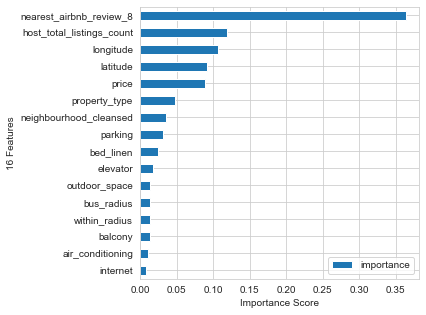

In [243]:
feat_imp = pd.DataFrame({'importance':rf_2.feature_importances_})  
feat_imp['feature'] = X_train_2.columns

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp = feat_imp[len(feat_imp1)-16:len(feat_imp1)]
feat_imp.plot.barh(figsize=(5,5))
plt.xlabel('Importance Score')
plt.ylabel('16 Features')
plt.show()

In [244]:
mse = sklearn.metrics.mean_squared_error(y_test_2, y_predict_rf_2)  
mae_rf_2 = sklearn.metrics.mean_absolute_error(y_test_2, y_predict_rf_2) 

rmse_rf_2 = math.sqrt(mse)  

print("RMSE = ", rmse_rf_2)
print("MAE = ", mae_rf_2)

RMSE =  0.27042598602524387
MAE =  0.1917966943552466


In [40]:
import pickle
# save the model to disk
filename = 'review-rf02.sav'
pickle.dump(rf, open(filename, 'wb'))

### 2. Gradient boosting regression

In [225]:
# Define hyperparameter grid to search over
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.03, 0.06],
    'max_features': ['sqrt', 'log2', None],
}

# Define the Random Forest classifier model
gb = GradientBoostingRegressor()

# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(
    gb, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X_train_2, y_train_2)

# Print the best hyperparameters and resulting accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gavinyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection

Best hyperparameters:  {'learning_rate': 0.03, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 40}
Best accuracy score:  -0.3179731174922256


In [245]:
grad_boosting_tree_2 = GradientBoostingRegressor(n_estimators=40, learning_rate = 0.03, max_features = 'sqrt', 
                                               max_depth = 10, random_state=42)

grad_boosting_tree_2.fit(X_train_2, y_train_2)
y_predict_gb_2 = grad_boosting_tree_2.predict(X_test_2)

In [246]:
importancesRF = grad_boosting_tree_2.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_2.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
nearest_airbnb_review_8,0.369075
host_total_listings_count,0.123353
longitude,0.109173
price,0.100254
latitude,0.093464


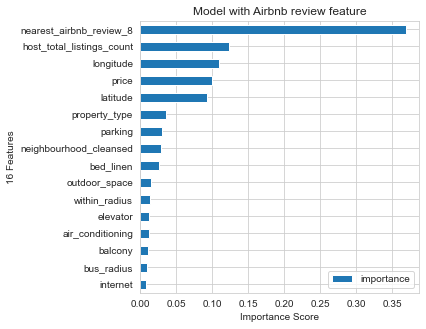

In [247]:
feat_imp = pd.DataFrame({'importance':grad_boosting_tree_2.feature_importances_})  
feat_imp['feature'] = X_train_2.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp = feat_imp[len(feat_imp1)-16:len(feat_imp1)]
feat_imp.plot.barh(figsize=(5,5))
plt.xlabel('Importance Score')
plt.ylabel('16 Features')
plt.title('Model with Airbnb review feature')
f= plt.gcf()
plt.show()
f.savefig('gb_importance_16.png', dpi=300, bbox_inches='tight')

In [248]:
mse = sklearn.metrics.mean_squared_error(y_test_2, y_predict_gb_2)  
mae_gb_2 = sklearn.metrics.mean_absolute_error(y_test_2, y_predict_gb_2) 

rmse_gb_2 = math.sqrt(mse)  

print("RMSE = ", rmse_gb_2)
print("MAE = ", mae_gb_2)

RMSE =  0.2606331079279963
MAE =  0.18754293910443956


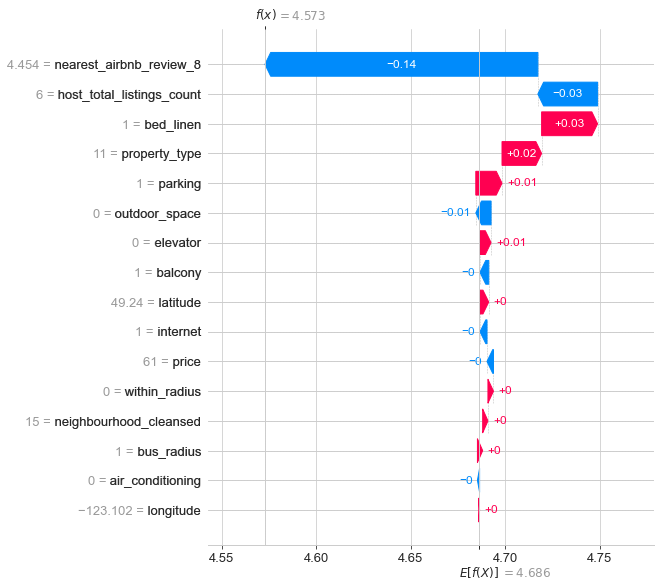

In [249]:
explainer = shap.Explainer(grad_boosting_tree_2)
shap_values = explainer(X_test_2)

class helper_object():
    """
    This wraps the shap object.
    It takes as input i, which indicates the index of the observation to be explained.
    """
    def __init__(self, i):
        self.base_values = shap_values.base_values[i][0]
        self.data = X_test_2.loc[i]
        self.feature_names = X_test_2.columns.to_list()
        self.values = shap_values.values[i]
f=plt.gcf()
shap.waterfall_plot(helper_object(0), len(shap_values[0]))
f.savefig("gb_waterfall_16.png", dpi=300, bbox_inches="tight")

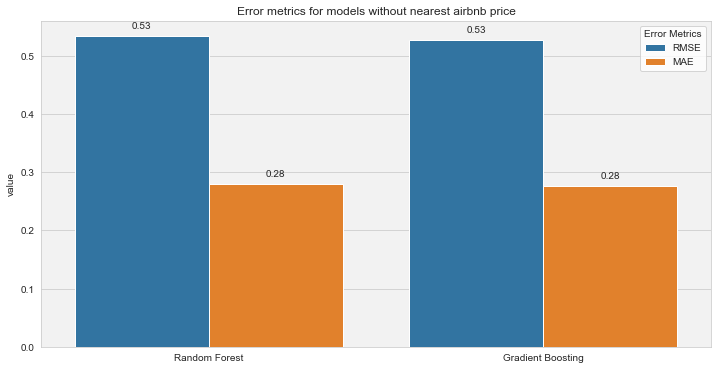

In [250]:
data = {' ': ['Random Forest', 'Random Forest','Gradient Boosting', 'Gradient Boosting'],
        'Error Metrics': ['RMSE', 'MAE', 'RMSE', 'MAE'],
        'value': [rmse_rf_1, mae_rf_1, rmse_gb_1, mae_gb_1]}
df_scores = pd.DataFrame(data)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=" ", y="value", hue="Error Metrics", data=df_scores)
ax.set_title('Error metrics for models without nearest airbnb price')

ax.set_facecolor('#f2f2f2')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=10)
plt.savefig('barplot_model_1.png', dpi=300, bbox_inches='tight')

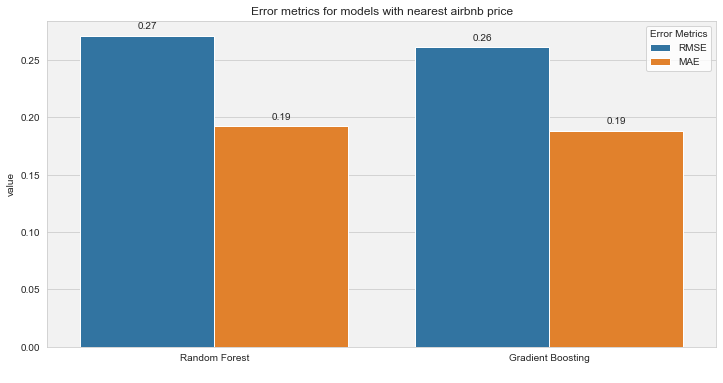

In [251]:
data = {' ': ['Random Forest', 'Random Forest', 'Gradient Boosting', 'Gradient Boosting'],
        'Error Metrics': ['RMSE', 'MAE', 'RMSE', 'MAE'],
        'value': [rmse_rf_2, mae_rf_2, rmse_gb_2, mae_gb_2]}
df_scores = pd.DataFrame(data)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=" ", y="value", hue="Error Metrics", data=df_scores)
ax.set_title('Error metrics for models with nearest airbnb price')

ax.set_facecolor('#f2f2f2')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=10)
plt.savefig('barplot_model_2.png', dpi=300, bbox_inches='tight')